# Project 3 - Classifying Reddit posts

---

## Problem Statement
Given students' changing attitudes on unethical behaviors, and given corporations' increasingly-rigorous job applicant screening processes, are models based on natural language processing sophisticated enough to distinguish the linguistic nuances between ethical, unethical, and illegal behaviors posted online?  Could these models be the basis for more sophiticated job screeing tools in the future, and therefore put already ethically at-risk students at even more more of a disadvantage for employment. What are the implications and actions for educators?

---

## Executive summary
A recent study by professors at California State University, San Marcos and San Francisco State University, found that students' who were more open to cheating at school also were more open to unethical behavior later on in their jobs and careers. In addition, the study found that 'group-oriented' students had a more relaxed attitude toward cheating than more 'individualistic' students. (1)

A report by Career Builder.com found that up to 70% of businesses use social media as a screening tool for job applicants and new hires.(2)  Top reasons for job denial include: 
- Provocative/inappropriate content, photos, videos = 40%
- Alcohol and drug use = 36%
- Descrimination againse race,gender, religion = 31%
- Illegal and criminal behavior = 30%

Is machine learning sophisticated enough to distinguish linguistic nuances between ethical, unethical, and illegal behaviors posted online and how does this affect students and educators?

A high-level study was conducted on Reddit posts spanning the 'Life Pro Tip' , the 'Unethical Life Pro Tip', and the 'Illegal Life Pro Tip' subreddit groups using the following modelling techniques to determine the predictive capabilities of machine learning. 
- CountVectorizer / TfidfVectorizer
- Logistic Regression
- Naïve Bayes: Binomial/ Multinomial
- Support Vector
- Decision Tree

---

## Notebook Contents
1. Gathering data
- Cleaning data
- Modelling data
>- Model 1: Logistic Regression, Naive Bayes
>- Model 2: Logistic Regression, Naive Bayes, Support Vector Classification
>- Model 3: Logistic Regression, Naive Bayes, Decision Tree

---

## Results

Three sets of data were run:
- Data 1 = Predicting Unethical vs Ethical posts
- Data 2 = Predicting Illegal vs Unethical posts
- Data 3 = Predicting Illegal vs Ethical posts

Overall results concerning all 3 data sets:
- Titles more accurate than selftext
- Tvec more accurate than Cvec
- Stopwords not an influence - even when creating custom stopword list
- LogReg most accurate model!
- Multinomial Naïve Bayes slightly less accuracy than LogReg but consistently higher Specificity
- Support Vector similar accuracy to LogReg, but with higher overfit and HUGE Time/CPU cost.
- Decision Tree (even with up to 90 levels) ran surprisingly quickly, but had slightly less accuracy than LogReg and had the highest overfit.

Results for best fit models:

|Dataset|Reddit|Baseline|Best model|Results|
|---|---|---|---|---|
|Data1|Unethical vs Ethical|54%|Tvec and LogReg| Accuracy 78%|
|Data2|Illegal vs Unethical| 52%| Tvec and LogReg|Accuracy 76%|
|Data3|Illegal vs Ethical|52%|Tvec and LogReg|Accuracy 90%|

---

## Conclusions and Recommendations

Simple modeling yields reasonable accuracy in predicting if a post and its associated behavior can be categorized as unethical or illegal.  More data sourced, additional feature engineering, and more modelling tecniques will increase accuracy.  It is reasonable to assume employers are capable of screening students and new job candidates based on machine learning nuanced language.

Recommendations:
- Expand on current study to : 1) ensure modelling accuracy, and 2) refine how online groups influence students’ ‘collectivism’
- Advise University Career Services to enact stricter guidance to graduating students about cleaning and maintaining social profiles.
- Approach University staff to urge more overall education in Ethics.  Ethics is standard study for many disciplines, medical, legal, business, theology.  Increased education in ethics at an earlier stage can begin to curb unhealthy attitudes toward scholastic cheating.


(1)https://www.sciencedaily.com/releases/2019/11/191127121235.htm
(2)https://www.cnbc.com/2018/08/10/digital-dirt-may-nix-that-job-you-were-counting-on-getting.html

---

Online posts sraped from following subreddits:
- LifeProTips='https://www.reddit.com/r/LifeProTips.json'
- UnethicalLifeProTips='https://www.reddit.com/r/UnethicalLifeProTips.json'
- IllegalLifePro Tips='https://www.reddit.com/r/IllegalLifeProTips.json'

|Feature|Type|Subreddit/dataset|Description|
|---|---|---|---|
|title|string |Regular'Ethical'/Unethical/Illegal Life Pro Tips|Title of the post|
|selftext|string|Ethical/Unethical/Illegal|Body of the text|
|subreddit|string/int|Ethical/Unethical/Illegal|Identifier for specific subreddit|
|author|string|Ethical/Unethical/Illegal|Author of post|
|num_comments|int|Ethical/Unethical/Illegal|Number of comments per post|
|score|int|Ethical/Unethical/illegal|Score (thumbs up) per post|
|is_self|string|Ethical/Unethical/Illegal|Reddit indicatro of type of post|
|created_UTC/timestamp|date/time|Ethical/Unethical/Illegal|Timestamps for post|


## 1. Importing tools and data
### Import tools

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import r2_score

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Scrape data from the following websits
- my_url='https://www.reddit.com/r/LifeProTips.json'
- my_url='https://www.reddit.com/r/UnethicalLifeProTips.json'
- my_url='https://www.reddit.com/r/IllegalLifeProTips.json'
 

### 1.1 Original request code for data gathering 
### Code not used, but saved as reference for alternative data gathering method
#### Connect to reddit pages and make sure status code is good #### Double click here to see the code

my_url='https://www.reddit.com/r/LifeProTips.json'
my_url='https://www.reddit.com/r/UnethicalLifeProTips.json'
my_url='https://www.reddit.com/r/IllegalLifeProTips.json'

my_header={'User-agent':'gg_agent'}
res=requests.get(my_url,headers=my_header)
my_json=res.json()
res.status_code, my_json['data']['after']

#### Pull reddit posts and save to a file #### Double click here to see the code

post=[]
after=None
for i in range(300):
    if after==None:
        params={}
    else:params={'after':after}
    res=requests.get(my_url,headers=my_header,params=params)
    if res.status_code==200:
        my_json=res.json()
        post.extend(my_json['data']['children'])
        after=my_json['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(2)  # this slows the code down to signal reddit you are not hostile
    #print(i)
    if i>0 and i%5==0:
        pd.DataFrame(post).to_csv('ILPT_reddit.csv',index=False)
        print(f"Saved {len(post)} posts")
        


df = df.drop_duplicates(subset='data', keep="first")
df.reset_index(drop=True,inplace=True)
type(eval(df.data.iloc[2]))
df['subreddit'], df['title'], df['selftext'], df['num_comments']= ['x', 'y', 'z', 0]

#we pull out the dictionary values we want
my_colnames= ['subreddit','title', 'selftext','num_comments']
for j in my_colnames:
    for i in range(0,len(df)):
        df[j][i] = eval(df.data.iloc[i])[j]    

#I notice some of the messages are reddit notifications and not real posts
#this function selects those posts with 'LPT" in it (ie LPT and ULPT and ILPT) and discards the rest
df = df[df['title'].str.contains("LPT")]
len(df)


### 1.2 PushIO code for data gathering
#### BIG THANKS TO RAFFY for sharing  #### Double click to see code


import datetime as dt
def get_date(created):
    # get the date of post
    return dt.date.fromtimestamp(created)

def query_pushshift(subreddit, kind='submission', skip=5, times=50, 
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments',
                                'score', 'is_self'],
                    comfields = ['body', 'score', 'created_utc']):
    # get the base url that contains information I want to scrape where 'kind' are all submitted posts
    # and 'subreddit' is the specified subreddit. Get 500 posts.
    stem = f"https://api.pushshift.io/reddit/search/{kind}/?subreddit={subreddit}&size=500"
    # instantiate list to contain 
    mylist = []
    # scrape posts from the subreddit 'times' times
    for x in range(1, times + 1):
        # Get posts 'skip' * 'x' days ago
        URL = f"{stem}&after={skip * x}d"
        print(URL)
        # Scrape URL
        response = requests.get(URL)
        # Give me an AssertionError if status code not 200
        assert response.status_code == 200
        # Of the HTML scraped, take the values of 'data'
        the_json=response.json()
        no_blanks=[c for c in the_json['data'] if ('selftext' in c.keys()) and len(c['selftext'])>10]
        # turn the data into a dataframe
        df = pd.DataFrame.from_dict(no_blanks)
        # append the dataframe to mylist
        mylist.append(df)
        # wait to not overrun Reddit's resources
        time.sleep(3)
    # concatenate the dataframes together as one large dataframe, full
    full = pd.concat(mylist, sort=False)
    if kind == "submission":
        # take all speficied data
        full = full[subfield]
        # drop duplicate rows
        full = full.drop_duplicates()
        full = full.loc[full['is_self'] == True]
    # date the the post was... posted
    _timestamp = full["created_utc"].apply(get_date)
    full['timestamp'] = _timestamp
    print(full.shape)
    return full

In [2]:
#df_uneth = query_pushshift(subreddit = 'unethicallifeprotips', skip = 1, times=300)

#df_eth.to_csv("eth_reddit.csv",index=False, header=True)
df_uneth.to_csv("uneth_reddit.csv", index=False, header=True)
#df_illegal.to_csv("illegal_reddit.csv", index=False, header = True)

## 2. Clean Data
#### Please note, the following code was run several times to create multiple datasets

In [3]:
#df = pd.read_csv('eth_reddit.csv')
df = pd.read_csv('uneth_reddit.csv')
#df = pd.read_csv('illegal_reddit.csv')
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,ULPT - Got some business cards of people you d...,"Keep 'em! If you ever hit a parked car, write ...",UnethicalLifeProTips,1580345880,cibtd,4,1,True,2020-01-29
1,ULPT Request: How to return an unwanted survei...,Won a raffle and the prize was a google smart ...,UnethicalLifeProTips,1580346688,2humps1camel,6,1,True,2020-01-29
2,ULPT Request: I need a free White Pages Premiu...,Anyone know how I might accomplish that?,UnethicalLifeProTips,1580349400,YetAnotherStepBack,1,1,True,2020-01-29
3,ULPT: Help improve vaccination rates by encour...,"Next flu season, vaccination rates will be hig...",UnethicalLifeProTips,1580350376,cramduck,277,1,True,2020-01-29
4,ULPT: How to get away with anything using a ca...,Place one or multiple cameras in the area you ...,UnethicalLifeProTips,1580350881,becuziwasinverted,4,1,True,2020-01-29


In [4]:
# REALLY cool function to aid in editing string!
import string

# this function removes the LPT or ULPT or ILPT from the start of the title
# otherwise it would be too easy to predict the post!
df['title'] = df['title'].str.lstrip('ILPT:')
df['title'] = df['title'].str.lstrip('ULPT:')
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,- Got some business cards of people you don't...,"Keep 'em! If you ever hit a parked car, write ...",UnethicalLifeProTips,1580345880,cibtd,4,1,True,2020-01-29
1,Request: How to return an unwanted surveillan...,Won a raffle and the prize was a google smart ...,UnethicalLifeProTips,1580346688,2humps1camel,6,1,True,2020-01-29
2,Request: I need a free White Pages Premium ac...,Anyone know how I might accomplish that?,UnethicalLifeProTips,1580349400,YetAnotherStepBack,1,1,True,2020-01-29
3,Help improve vaccination rates by encouraging...,"Next flu season, vaccination rates will be hig...",UnethicalLifeProTips,1580350376,cramduck,277,1,True,2020-01-29
4,How to get away with anything using a camera!,Place one or multiple cameras in the area you ...,UnethicalLifeProTips,1580350881,becuziwasinverted,4,1,True,2020-01-29


In [5]:
# this function removes the word 'Request' from the start of the title 
# I noticed that many of the 'illegal'LPT were requests and this could sway results
#DECISION made to remove "request" from all posts
df['title'] = df['title'].str.lstrip(' Request:')
df['title'] = df['title'].str.lstrip(' request:')
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,- Got some business cards of people you don't ...,"Keep 'em! If you ever hit a parked car, write ...",UnethicalLifeProTips,1580345880,cibtd,4,1,True,2020-01-29
1,How to return an unwanted surveillance device ...,Won a raffle and the prize was a google smart ...,UnethicalLifeProTips,1580346688,2humps1camel,6,1,True,2020-01-29
2,I need a free White Pages Premium account.,Anyone know how I might accomplish that?,UnethicalLifeProTips,1580349400,YetAnotherStepBack,1,1,True,2020-01-29
3,Help improve vaccination rates by encouraging ...,"Next flu season, vaccination rates will be hig...",UnethicalLifeProTips,1580350376,cramduck,277,1,True,2020-01-29
4,How to get away with anything using a camera!,Place one or multiple cameras in the area you ...,UnethicalLifeProTips,1580350881,becuziwasinverted,4,1,True,2020-01-29


In [6]:
len(df)

7154

In [7]:
# we get rid of posts with little/ no text in title
df = df.drop(df[df.title.str.len() < 20].index)
len(df)

6768

In [8]:
# get rid of posts with duplicate titles
df = df.drop_duplicates(subset='title', keep="first")
len(df)

6679

In [9]:
# We get rid of posts with little/ no text in selftext
df = df.drop(df[df.selftext.str.len() < 20].index)
len(df)

6614

In [10]:
# get rid of posts with duplicate selftexts
df = df.drop_duplicates(subset='selftext', keep="first")
len(df)

6501

In [11]:
# we drop posts where the selftext is just a website
df = df.drop(df[df['selftext'].str.match('http')].index)
df = df.drop(df[df['selftext'].str.match('\\[http')].index)
len(df)

6447

In [12]:
# we notice we still have some duplicate posts - users add spaces, punctuation, words, or CAPS to make posts different
# I look at 'hi-volume' posters to see if we have any hi-volumen offenders.... and we DON'T!
df.author.value_counts().loc[df.author.value_counts() >=10 ]
# Decsion made to assume the risk of keeping duplicate posts.

dirtymoney      19
sportscience    15
noway2019       13
_MrUnethical    10
Name: author, dtype: int64

In [13]:
# let's create feature =  title + selftext 
df['title_selftext'] = df['title']+df['selftext']
df.tail(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_selftext
7152,Getting pulled over for using your smartphone?...,Most state laws and local ordinances against u...,UnethicalLifeProTips,1554586946,Zer0Summoner,2,0,True,2019-04-06,Getting pulled over for using your smartphone?...
7153,Why don't Americans celebrate easter?,Don't tell me they do or you're just a filthy ...,UnethicalLifeProTips,1554595975,prototype_4,1,1,True,2019-04-06,Why don't Americans celebrate easter?Don't tel...


### Some very simple EDA

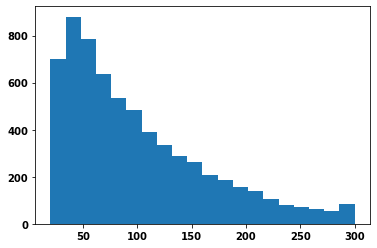

In [14]:
# this is histogram - character length of title
plt.hist(df.title.str.len(), bins=20);
# An interesting distribution

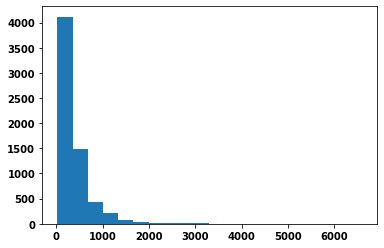

In [15]:
# hisogram - character lenght of self text
plt.hist(df.selftext.str.len(), bins=20);
# most selftext is very short - a few outliers

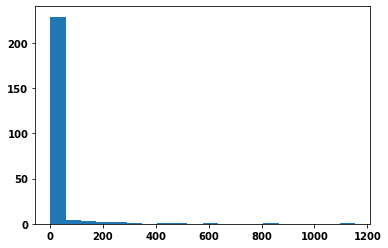

In [16]:
# histogram - number of comments
plt.hist(df.num_comments.value_counts()  , bins=20);
# most posts have below 25 comments - but many are very active

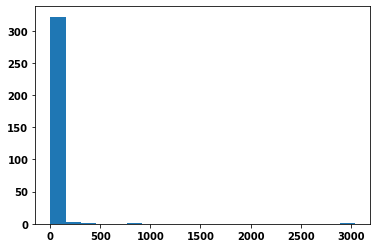

In [17]:
# histogram - number of score
plt.hist(df.score.value_counts()  , bins=20);
# most posts have ow score - few outiers

### Save data to files

In [18]:
# these have been commented out to prevent any overwriting

# Our 'ethical and unethical' data
#df.to_csv('data_eth.csv', index=False, header=True)

# our 'illegal and unethical' data
#df.to_csv('data_uneth.csv', index=False, header=True)

# our 'illegal' LPT posts
#df.to_csv('data_illegal.csv', index=False, header=True)


### Read in our cleaned data

In [19]:
# becuase data was cleaned and saved earlier, we don't have to worry about  the risk of over-writing
data_eth=pd.read_csv('data_eth.csv')
data_uneth=pd.read_csv('data_uneth.csv')
data_illegal=pd.read_csv('data_illegal.csv')
len(data_eth), len(data_uneth), len(data_illegal)

(7613, 6447, 7128)

## 3.0 Modeling
### Create baseline(s)

In [20]:
#Baseline for Data1 Unethical(1) vs Ethical(0) LPT posts
data1 = pd.concat([data_eth, data_uneth], ignore_index=True)
data1[['subreddit']]= data1[['subreddit']].replace({'LifeProTips':0,'UnethicalLifeProTips':1})

y = data1.subreddit
X = data1.title
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print("Data= Unethical vs Ethical")
print(y_test.value_counts(normalize=True))
    
# Baseline of 76.3%

Data= Unethical vs Ethical
0    0.541394
1    0.458606
Name: subreddit, dtype: float64


In [21]:
#Baseline for Data2 Illegal(1) vs Unethical(0) LPT posts
data2 = pd.concat([data_uneth, data_illegal], ignore_index=True)
data2[['subreddit']]= data2[['subreddit']].replace({'UnethicalLifeProTips':0,'IllegalLifeProTips':1})

y = data2.subreddit
X = data2.title
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print("Data= Illegal vs Unethical")
print(y_test.value_counts(normalize=True))
    
# Baseline of 61.4%

Data= Illegal vs Unethical
1    0.525044
0    0.474956
Name: subreddit, dtype: float64


In [22]:
#Baseline for Data3 Illegal(1) vs Ethical(0) LPT posts
data3 = pd.concat([data_eth, data_illegal], ignore_index=True)
data3[['subreddit']]= data3[['subreddit']].replace({'LifeProTips':0,'IllegalLifeProTips':1})

y = data3.subreddit
X = data3.title
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print("Data= Illegal vs Unethical")
print(y_test.value_counts(normalize=True))
    
# Baseline of 66.8%

Data= Illegal vs Unethical
0    0.516549
1    0.483451
Name: subreddit, dtype: float64


# 3.0 Data Modeling
## 3.1 Data 1 - Predicting Unethical vs Ethical Life Pro Tips
### 3.1.1 Model 1.1 = Vectorizers and LogReg 

In [51]:
# CREATE PIPES for Vectorizers and Logreg

# Vectorizer features
my_max_features=[1200,1500]  # these features fine-tuned 
my_stop_words=[None]  #'english' stopwords removed, not significant
my_ngram_range=[(1,1),(1,2)]
my_min_df= [1,2] 
#my_max_df=[0.80, 0.90]  # this was not significant


# pipe and parameters for cvec
pipeC = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='lbfgs'))])

    
pipeC_params = {
    'cvec__max_features': my_max_features,
    'cvec__min_df': my_min_df,
    #'cvec__max_df': my_max_df,
    'cvec__stop_words': my_stop_words,
    'cvec__ngram_range': my_ngram_range
    }
    

# pipe and parameters for tvec
pipeT = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='lbfgs'))])


pipeT_params = {
    'tvec__max_features': my_max_features,
    'tvec__min_df': my_min_df,
    #'tvec__max_df': my_max_df,    # not significant
    'tvec__stop_words': my_stop_words,
    'tvec__ngram_range': my_ngram_range,
    }
 
my_data=['title','selftext']  #selftext and title_selftext removed
my_pipes=[pipeT,pipeC]  # PipeC removed
my_pipeparams=[pipeT_params,pipeC_params]
my_pipenames = ['TVectorizer','Cvec']

In [52]:
# Loops designed to iterate thru various models to find best fit

for j in my_data:

    X = data1[j]
    y = data1['subreddit']      
    X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42, stratify=y))

    for i in range(0,len(my_pipenames)):

        gs = GridSearchCV(my_pipes[i], param_grid=my_pipeparams[i], cv=3) 
        gs.fit(X_train, y_train)
        gs_bestmodel = gs.best_estimator_
    
        print(f"Data1 {j}")
        print(f"Model = {my_pipenames[i]}")
        print(f"GridSearch best params = \n{gs.best_params_}")
        print(f"GridSearch best score = {gs.best_score_}")
        print(f"GS train score = {gs_bestmodel.score(X_train, y_train)}")
        print(f"GS test score  = {gs_bestmodel.score(X_test, y_test)}")
        print()
 
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")  
print(f"Model 1, data1 = Predicting Unethical vs Ethical Life Pro Tips, using vectorizers and logreg")

Data1 title
Model = TVectorizer
GridSearch best params = 
{'tvec__max_features': 1500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
GridSearch best score = 0.7751541014698909
GS train score = 0.82475106685633
GS test score  = 0.7817923186344239



C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Data1 title
Model = Cvec
GridSearch best params = 
{'cvec__max_features': 1200, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
GridSearch best score = 0.7655761024182077
GS train score = 0.8304409672830726
GS test score  = 0.761877667140825

Data1 selftext
Model = TVectorizer
GridSearch best params = 
{'tvec__max_features': 1500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
GridSearch best score = 0.7519203413940256
GS train score = 0.811284969179706
GS test score  = 0.748221906116643



C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\msgig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Data1 selftext
Model = Cvec
GridSearch best params = 
{'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
GridSearch best score = 0.7266002844950213
GS train score = 0.8209577999051684
GS test score  = 0.7280227596017069

Baseline= 
0    0.541394
1    0.458606
Name: subreddit, dtype: float64
Model 1, data1 = Predicting Unethical vs Ethical Life Pro Tips, using vectorizers and logreg


### Model 1.1 ,Confusion Matrix

In [25]:
y_pred = gs_bestmodel.fit(X_train, y_train).predict(X_test) 
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (ethical)', 'Predicted P (Unethical)'],index=['Actual N (ethical)', 'Actual P (Unethical)'])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")

Confusion Matrix:
                      Predicted N (ethical)  Predicted P (Unethical)
Actual N (ethical)                     1595                      308
Actual P (Unethical)                    459                     1153

Sensitivity = 0.7152605459057072
Specificity = 0.838150289017341
Accuracy = 0.7817923186344239


### Model 1.2 = data1, Vectorizer and Naive Bayes

In [26]:
my_NBmodels=[BernoulliNB(), MultinomialNB()]
my_NBmodelnames=['Bernoulli','Multinomial']

X = data1.title  # our best data
y = data1.subreddit
X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

#Taking our 'best' model from above
tvec = TfidfVectorizer(max_features= 1500, ngram_range= (1, 1), stop_words=None, )

X_train = tvec.fit_transform(X_train).toarray()
X_test = tvec.transform(X_test).toarray()
print()

for i in range(0,len(my_NBmodelnames)):
    nb = my_NBmodels[i]
    y_pred = nb.fit(X_train, y_train).predict(X_test)   
    
    print(f"NBmodel = {my_NBmodelnames[i]}")
    print(f" train score = {nb.score(X_train, y_train)}")
    print(f" test score  = {nb.score(X_test, y_test)}")
    print()
    
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")    
print(f"Model 2 , data2, predicting unethical vs ethical LPT with Tvec/NB")


NBmodel = Bernoulli
 train score = 0.7889995258416311
 test score  = 0.7647226173541963

NBmodel = Multinomial
 train score = 0.8006638217164533
 test score  = 0.7752489331436699

Baseline= 
0    0.541394
1    0.458606
Name: subreddit, dtype: float64
Model 2 , data2, predicting unethical vs ethical LPT with Tvec/NB


### Model 1.2 Confusion Matrix

In [27]:
y_pred = nb.fit(X_train, y_train).predict(X_test) 
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (ethical)', 'Predicted P (Unethical)'], 
                     index=['Actual N (ethical)', 'Actual P (Unethical)'])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")


Confusion Matrix:
                      Predicted N (ethical)  Predicted P (Unethical)
Actual N (ethical)                     1579                      324
Actual P (Unethical)                    466                     1146

Sensitivity = 0.7109181141439206
Specificity = 0.8297425118234367
Accuracy = 0.7752489331436699


>## Model 1 
>### GENERAL FINDINGS for all 3 datasets - 
>- **Title has more 'weight' than selftext.** In ALL 3 datasets the TITLE yielded the highest scores for accuracy as compared to selftext and title_selftext combo.  Indeed, selftext generated non-convergence warnings.  I suspect this is because the titles were generally very descriptive. 
>- **Tvec is more accurate than Cvec.**  In ALL 3 datasets, Tvec yeilded consistently slightly higher scores and when pushed for tuning Cvec often generated non-convergence warnings.
>- **LogReg is more accurate than Naive Bayes.**  In ALL 3 datasets LogReg was slightly more accurate than NB.  In addition, in ALL 3 datasets, MultinomialNB is slightly more accurate than BinomialNB.  ALthough NB generated slightly less accurate models than LogReg, its overfit was slightly less, but its results were consistenly skewed to higher SPECIFICITY (not SENSITIVITY).



## 3.2 Modelling Data 2 - Predicting Illegal vs Unethical Life Pro Tips
###  Model 2.1 = data 2  ,  Vectorizers and LogReg (and SVC)

In [28]:
# Vectorizer features
my_max_features=[1100,1200]  # these features fine-tuned 
my_stop_words=[None]  #'english' stopwords removed, not significant
my_ngram_range=[(1,1),(1,2)]
my_min_df= [2,3] 
#my_max_df=[0.80, 0.90]  # this was not significant


# SVC features  MORE ON SVC LATER
my_C= [1,5,10, 20]
my_kernel=['linear','rbf']
my_gamma= ['auto','scale']


# pipe and parameters for cvec
#pipeC = Pipeline([
    #('cvec', CountVectorizer()),
    #('logreg', LogisticRegression(solver='lbfgs'))])

#pipeC2 = Pipeline([
    #('cvec', CountVectorizer()),
    #('svc', SVC())]) 
    
#pipeC_params = {
    #'cvec__max_features': my_max_features,
    #'cvec__min_df': my_min_df,
    #'cvec__max_df': my_max_df,
    #'cvec__stop_words': my_stop_words,
    #'cvec__ngram_range': my_ngram_range,
    #'svc__C': my_C,
    #'svc__kernel': my_kernel,
    #'svc__gamma': my_gamma
    #}
    

# pipe and parameters for tvec
pipeT = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='lbfgs'))])

#pipeT2 = Pipeline([
    #('tvec', TfidfVectorizer()),
    #('svc', SVC())])


pipeT_params = {
    'tvec__max_features': my_max_features,
    'tvec__min_df': my_min_df,
    #'tvec__max_df': my_max_df,    
    'tvec__stop_words': my_stop_words,
    'tvec__ngram_range': my_ngram_range,
    #'svc__C': my_C,
    #'svc__kernel': my_kernel,
    #'svc__gamma': my_gamma
    }
 
my_data=['title']  #selftext and title_selftext removed due to non-convergence
my_pipes=[pipeT]  # PipeC removed due to lower score/higher overfit
my_pipeparams=[pipeT_params]
my_pipenames = ['TVectorizer']

In [29]:
for j in my_data:

    X = data2[j]
    y = data2['subreddit']   
    X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

    for i in range(0,len(my_pipenames)):

        gs = GridSearchCV(my_pipes[i],param_grid=my_pipeparams[i],cv=3) 
        gs.fit(X_train, y_train)
        gs_bestmodel = gs.best_estimator_
    
        print(f"Data2 {j}")
        print(f"Model = {my_pipenames[i]}")
        print(f"GridSearch best params = \n{gs.best_params_}")  
        print(f"GridSearch best score = {gs.best_score_}")
        print(f"GS train score = {gs_bestmodel.score(X_train, y_train)}")
        print(f"GS test score  = {gs_bestmodel.score(X_test, y_test)}")
        print()
 
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")  
print(f"Model 2 , data2 = Predicting Illegal vs Unethical Life Pro Tips, using vectorizers and logreg")


Data2 title
Model = TVectorizer
GridSearch best params = 
{'tvec__max_features': 1200, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
GridSearch best score = 0.7645614379726943
GS train score = 0.8099400844710736
GS test score  = 0.7604596346493813

Baseline= 
1    0.525044
0    0.474956
Name: subreddit, dtype: float64
Model 2 , data2 = Predicting Illegal vs Unethical Life Pro Tips, using vectorizers and logreg


### Model 2.1, confusion matrix

In [30]:
y_pred = gs_bestmodel.fit(X_train, y_train).predict(X_test) 
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (unethical)', 'Predicted P (Illegal)'], 
                     index=['Actual N (unethical)', 'Actual P (Illegal)'])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")


Confusion Matrix:
                      Predicted N (unethical)  Predicted P (Illegal)
Actual N (unethical)                     1156                    456
Actual P (Illegal)                        357                   1425

Sensitivity = 0.7996632996632996
Specificity = 0.71712158808933
Accuracy = 0.7604596346493813


### Model 2.2 =  data2, vectorizer and Naive Bayes

In [31]:
my_NBmodels=[BernoulliNB(), MultinomialNB()]
my_NBmodelnames=['Bernoulli','Multinomial']

X = data2.title  # our best data
y = data2.subreddit
X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

#Taking our 'best' model from above
tvec = TfidfVectorizer(max_features= 1200, min_df= 2, ngram_range= (1, 2), stop_words=None, )

X_train = tvec.fit_transform(X_train).toarray()
X_test = tvec.transform(X_test).toarray()
print()

for i in range(0,len(my_NBmodelnames)):
    nb = my_NBmodels[i]
    y_pred = nb.fit(X_train, y_train).predict(X_test)   
    
    print(f"NBmodel = {my_NBmodelnames[i]}")
    print(f" train score = {nb.score(X_train, y_train)}")
    print(f" test score  = {nb.score(X_test, y_test)}")
    print()
    
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")    
print(f"Model 2 = Ethical/ unethical with Tvec/NB")


NBmodel = Bernoulli
 train score = 0.7399076711521462
 test score  = 0.7292280494991161

NBmodel = Multinomial
 train score = 0.779687653472154
 test score  = 0.7457277548615203

Baseline= 
1    0.525044
0    0.474956
Name: subreddit, dtype: float64
Model 2 = Ethical/ unethical with Tvec/NB


### Model 2.2 Confusion Matrix

In [32]:
y_pred = nb.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (unethical)', 'Predicted P (Illegal)'], 
                     index=['Actual N (unethical)', 'Actual P (Illegal)'])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")


Confusion Matrix:
                      Predicted N (unethical)  Predicted P (Illegal)
Actual N (unethical)                     1115                    497
Actual P (Illegal)                        366                   1416

Sensitivity = 0.7946127946127947
Specificity = 0.6916873449131513
Accuracy = 0.7457277548615203


### Model 2.3 = data 2 and Vectorizer and SVC¶

### switched to markdown to avoid excessivly loooooong runs
### Click to see code

#pipe and parameters for tvec
pipeTsvc = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())])


pipeT_params = {
    'tvec__max_features': my_max_features,
    'tvec__min_df': my_min_df,
    #'tvec__max_df': my_max_df,    
    'tvec__stop_words': my_stop_words,
    'tvec__ngram_range': my_ngram_range,
    'svc__C': my_C,
    'svc__kernel': my_kernel,
    'svc__gamma': my_gamma
    }

#Vectorizer features
my_max_features=[1200]  # these features fine-tuned 
my_stop_words=[None]  #'english' stopwords removed, not significant
my_ngram_range=[(1,2)]
my_min_df= [2] 
#my_max_df=[0.80, 0.90]  # this was not significant


#SVC features
my_C= [1]
my_kernel=['rbf']
my_gamma= ['scale']

    
my_data=['title']  #selftext and title_selftext removed due to non-convergence
my_pipes=[pipeTsvc]  # PipeC removed due to lower score/higher overfit
my_pipeparams=[pipeT_params]
my_pipenames = ['TVec_SVC']

### Click to see code

for j in my_data:

    X = data2[j]
    y = data2['subreddit']   
    
    X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

    for i in range(0,len(my_pipenames)):

        gs = GridSearchCV(my_pipes[i], 
                  param_grid=my_pipeparams[i], 
                  cv=3) 
        gs.fit(X_train, y_train)
        gs_bestmodel = gs.best_estimator_
    
        print(f"Data2 {j}")
        print(f"Model = {my_pipenames[i]}")
        print(f"GridSearch best params = \n{gs.best_params_}") 
        print(f"GridSearch best score = {gs.best_score_}")
        print(f"GS train score = {gs_bestmodel.score(X_train, y_train)}")
        print(f"GS test score  = {gs_bestmodel.score(X_test, y_test)}")
        print()
 
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")  
print(f"Model 2 , data2 = Predicting Illegal vs Unethical Life Pro Tips, using vectorizers and logreg")

### Results of 'best' SVC model

**Data2 title**
**Model = TVec_SVC**
- GridSearch best params = 
- {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'tvec__max_features': 1200, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
- GridSearch best score = 0.7676063255082998
- GS train score = 0.9207347018956881
- GS test score  = 0.7622274602239246

**Baseline=** 
- 1    0.525044
- 0    0.474956
- Name: subreddit, dtype: float64
- Model 2 , data2 = Predicting Illegal vs Unethical Life Pro Tips, using vectorizers and logreg

>## Model 2
>### GENERAL FINDINGS for all 3 datasets
>- ALthough only shown in Model2/Data2, the following finding are for ALL 3 datasets.
>- **LogReg accuracy comparable to SVC Model but at a FRACTION of the time and CPU.**  Although SVC yielded similar Accuracy to LegReg, its overfit on the Train data was consistently much higher.
>- Code above is in markdown to prevent costly execution.



## 3.3 Modeling Data 3 - Predicting Illegal vs Ethical Life Pro Tips
### Model 3.1 = data 3, Vectorizers and LogReg 

In [33]:
#PIPES
# Vectorizer features
my_max_features=[1800,2000]  # these features fine-tuned 
my_stop_words=[None]  #'english' stopwords removed, not significant
my_ngram_range=[(1,1),(1,2)]
my_min_df= [2,3,4] 
#my_max_df=[0.80, 0.90]  # this was not significant  

#pipe and parameters for cvec
#pipeC = Pipeline([
    #('cvec', CountVectorizer()),
    #('logreg', LogisticRegression(solver='lbfgs'))])

#pipeC_params = {
    #'cvec__max_features': my_max_features,
    #'cvec__min_df': my_min_df,
    #'cvec__max_df': my_max_df,
    #'cvec__stop_words': my_stop_words,
    #'cvec__ngram_range': my_ngram_range
    #}
    

#pipe and parameters for tvec
pipeT = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='lbfgs'))])

pipeT_params = {
    'tvec__max_features': my_max_features,
    'tvec__min_df': my_min_df,
    #'tvec__max_df': my_max_df,    
    'tvec__stop_words': my_stop_words,
    'tvec__ngram_range': my_ngram_range
    }
   
my_data=['title']  #selftext and title_selftext removed due to non-convergence
my_pipes=[pipeT]  # PipeC removed due to lower score/higher overfit
my_pipeparams=[pipeT_params]
my_pipenames = ['TVectorizer']

In [34]:
for j in my_data:

    X = data3[j]
    y = data3['subreddit']
    X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

    for i in range(0,len(my_pipenames)):

        gs = GridSearchCV(my_pipes[i], param_grid=my_pipeparams[i], cv=3)  
        gs.fit(X_train, y_train)
        gs_bestmodel = gs.best_estimator_
    
        print(f"Data3 {j}")
        print(f"Model = {my_pipenames[i]}")
        print(f"GridSearch best params = \n{gs.best_params_}")
        print(f"GridSearch best score = {gs.best_score_}")
        print(f"GS train score = {gs_bestmodel.score(X_train, y_train)}")
        print(f"GS test score  = {gs_bestmodel.score(X_test, y_test)}")
        print()
 
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")  
print(f"Model 3 , data3 = Predicting Illegal vs Ethical LPTs using vectorizers and logreg")

Data3 title
Model = TVectorizer
GridSearch best params = 
{'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
GridSearch best score = 0.8903663500678426
GS train score = 0.9210312075983718
GS test score  = 0.8982637004883343

Baseline= 
0    0.516549
1    0.483451
Name: subreddit, dtype: float64
Model 3 , data3 = Predicting Illegal vs Ethical LPTs using vectorizers and logreg


### Model 3.1 , Confusion Matrix

In [35]:
y_pred = gs_bestmodel.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (ethical)', 'Predicted P (Illegal)'], 
                     index=['Actual N (ethical)', 'Actual P (Illegal)'])

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")

Confusion Matrix:
                    Predicted N (ethical)  Predicted P (Illegal)
Actual N (ethical)                   1722                    182
Actual P (Illegal)                    193                   1589

Sensitivity = 0.8916947250280584
Specificity = 0.9044117647058824
Accuracy = 0.8982637004883343


### Create ROC curve

In [36]:
pred_proba = [i[1] for i in gs_bestmodel.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
3373,0,0.070659
4569,0,0.172704
1975,0,0.023133
10723,1,0.049737
10515,1,0.781980


In [37]:
#let's get our ROC score
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9544057521998698

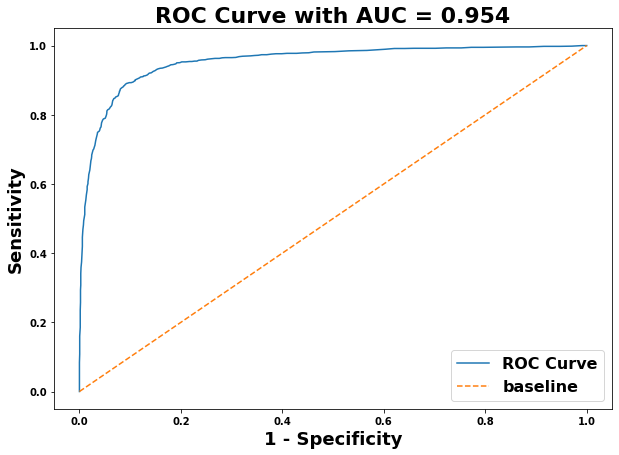

In [38]:
# Create figure for ROC to get an idea of sensitivity and specificity tradeoff
# this code is was provided in class

plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);
          
# curve looks good,a fair bit of separate for our two classes

### Model 3.2 = data3,  Vectorizer and NB

In [39]:
my_NBmodels=[BernoulliNB(), MultinomialNB()]
my_NBmodelnames=['Bernoulli','Multinomial']

X = data3.title  # our best data
y = data3.subreddit
X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

#Taking our 'best' model from above
tvec = TfidfVectorizer(max_features= 2000, ngram_range= (1, 1), stop_words=None, )

X_train = tvec.fit_transform(X_train).toarray()
X_test = tvec.transform(X_test).toarray()
print()

for i in range(0,len(my_NBmodelnames)):
    nb = my_NBmodels[i]
    y_pred = nb.fit(X_train, y_train).predict(X_test)   
    
    print(f"NBmodel = {my_NBmodelnames[i]}")
    print(f" train score = {nb.score(X_train, y_train)}")
    print(f" test score  = {nb.score(X_test, y_test)}")
    print()
    
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")    
print(f"Model 2 = Ethical/ unethical with Tvec/NB")


NBmodel = Bernoulli
 train score = 0.860153776571687
 test score  = 0.8480737927292458

NBmodel = Multinomial
 train score = 0.9075531433740389
 test score  = 0.887683125339121

Baseline= 
0    0.516549
1    0.483451
Name: subreddit, dtype: float64
Model 2 = Ethical/ unethical with Tvec/NB


### Model 3.2 Confusion Matrix

In [40]:
y_pred = nb.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (ethical)', 'Predicted P (Illegal)'], 
                     index=['Actual N (ethical)', 'Actual P (Illegal)'])

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")

Confusion Matrix:
                    Predicted N (ethical)  Predicted P (Illegal)
Actual N (ethical)                   1743                    161
Actual P (Illegal)                    253                   1529

Sensitivity = 0.8580246913580247
Specificity = 0.9154411764705882
Accuracy = 0.887683125339121


### Model 3.3 = data3,  Vectorizer and Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
#PIPES

#pipe and parameters for tvec
pipeT = Pipeline([
    ('tvec', TfidfVectorizer( max_features=600,stop_words=None )),
    ('dt', DecisionTreeClassifier(random_state = 42))
    ])

pipeT_params = {
            'dt__max_depth': [60,70],
            'dt__min_samples_split': [60,70],
            'dt__min_samples_leaf': [3, 5]
            }
    
my_data=['title']  #selftext and title_selftext removed due to non-convergence
my_pipes=[pipeT]  # PipeC removed due to lower score/higher overfit
my_pipeparams=[pipeT_params]
my_pipenames = ['TVec_Dtree']

In [43]:
for j in my_data:

    X = data3[j]
    y = data3['subreddit']

    X_train, X_test, y_train, y_test = (train_test_split(X, y, 
                                random_state=42, 
                                stratify=y))

    for i in range(0,len(my_pipenames)):

        gs = GridSearchCV(my_pipes[i], param_grid=my_pipeparams[i], cv=3 )  
        gs.fit(X_train, y_train)
        gs_bestmodel = gs.best_estimator_
    
        print(f"Data3 {j}")
        print(f"Model = {my_pipenames[i]}")
        print(f"GridSearch best params = \n{gs.best_params_}")
        print(f"GridSearch best score = {gs.best_score_}")
        print(f"GS train score = {gs_bestmodel.score(X_train, y_train)}")
        print(f"GS test score  = {gs_bestmodel.score(X_test, y_test)}")
        print()
 
print(f"Baseline= \n{y_test.value_counts(normalize=True)}")  
print(f"Model 3 , data3 = Predicting Illegal vs Ethical LPTs using vectorizers and logreg")

Data3 title
Model = TVec_Dtree
GridSearch best params = 
{'dt__max_depth': 60, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 60}
GridSearch best score = 0.8255088195386703
GS train score = 0.8850293984622343
GS test score  = 0.8260987520347259

Baseline= 
0    0.516549
1    0.483451
Name: subreddit, dtype: float64
Model 3 , data3 = Predicting Illegal vs Ethical LPTs using vectorizers and logreg


In [44]:
y_pred = gs_bestmodel.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)  # matrix of actual y and predicted y
cm_df = pd.DataFrame(cm, columns=['Predicted N (ethical)', 'Predicted P (Illegal)'], 
                     index=['Actual N (ethical)', 'Actual P (Illegal)'])

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix:')
print(cm_df)
print()
print(f"Sensitivity = {tp / (tp + fn)}")
print(f"Specificity = {tn/(tn+fp)}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")

Confusion Matrix:
                    Predicted N (ethical)  Predicted P (Illegal)
Actual N (ethical)                   1588                    316
Actual P (Illegal)                    325                   1457

Sensitivity = 0.8176206509539843
Specificity = 0.8340336134453782
Accuracy = 0.8260987520347259


#### If I wanted to create output for decsion tree, I'd have to vectorize the x data and save to array prior to running this function .. maybe later...


pd.DataFrame(resulting_sparse_matrix.toarray(), columns = tfidf_instance.get_feature_names())


from sklearn.tree import export_graphviz
export_graphviz(dt,
               out_file="./test.dot",
               feature_names=X_train.columns,
               class_names=['not survived','survived'],
               rounded=True,
               filled=True)

### Are there key words influencing accuracy

In [45]:
# I suspect some specific words may be triggering the high rate of prediction
my_stopwords=['ethical','unethical','legal','illegal','evil','bad', ]
my_data = ['title']

for j in my_stopwords:
    for i in my_data:
        print(f"Stopword {j} is found {data3[i].str.count(j).sum() } times in Data3 {i}")
        
# Wow, out of 14k of posts, am surprise there were so few of these

Stopword ethical is found 7 times in Data3 title
Stopword unethical is found 3 times in Data3 title
Stopword legal is found 153 times in Data3 title
Stopword illegal is found 86 times in Data3 title
Stopword evil is found 5 times in Data3 title
Stopword bad is found 107 times in Data3 title


In [46]:
# let's use cvec to get a lists of words and value counts!
X = data3.title_selftext
y = data3.subreddit
X_train, X_test, y_train, y_test = (train_test_split(X, y,random_state=42,stratify=y))

cv = CountVectorizer(stop_words='english')   
cv_fit=cv.fit_transform(X_train,y_train)    
word_list = cv.get_feature_names()
count_list = cv_fit.toarray().sum(axis=0).tolist()    

In [47]:
# putting words and counts together 
my_wordcount = pd.DataFrame(list(zip(word_list, count_list)),
              columns=['word','count'])
(my_wordcount.sort_values(by=['count']))

,word,count
30295,𝙩𝙧𝙮𝙞𝙣𝙜,1
14137,initiated,1
14138,initiates,1
14139,initiation,1
14142,injected,1
...,...,...
16451,make,2660
29179,want,2667
15861,like,3135
8808,don,3613


In [48]:
# taking any words with count of over 200 mentions and making my stopwords list
my_stopwords= my_wordcount.loc[my_wordcount['count'] > 200]['word'].tolist()
(my_stopwords)
# although not shown, Ran cvec and tvec models with my cstomer stop words and did not get any appredciable drop in scores

['10',
 '100',
 '15',
 '20',
 '2019',
 '30',
 '50',
 'able',
 'access',
 'account',
 'accounts',
 'actually',
 'add',
 'address',
 'advice',
 'ago',
 'amazon',
 'amp',
 'app',
 'apple',
 'apps',
 'area',
 'aren',
 'ask',
 'asked',
 'asking',
 'avoid',
 'away',
 'bad',
 'bag',
 'bank',
 'basically',
 'bed',
 'best',
 'better',
 'big',
 'bit',
 'body',
 'bottle',
 'bought',
 'box',
 'break',
 'bring',
 'business',
 'buy',
 'buying',
 'called',
 'came',
 'car',
 'card',
 'cards',
 'care',
 'case',
 'cash',
 'caught',
 'cause',
 'chance',
 'change',
 'charge',
 'cheap',
 'check',
 'christmas',
 'clean',
 'click',
 'close',
 'clothes',
 'code',
 'cold',
 'college',
 'com',
 'come',
 'comes',
 'coming',
 'company',
 'completely',
 'computer',
 'contact',
 'cost',
 'country',
 'couple',
 'course',
 'create',
 'credit',
 'cut',
 'date',
 'day',
 'days',
 'deal',
 'did',
 'didn',
 'different',
 'discord',
 'dna',
 'does',
 'doesn',
 'dog',
 'doing',
 'don',
 'dont',
 'door',
 'drink',
 'drive',

> ## Model 3
>### GENERAL FINDINGS for all 3 datasets
>- ALthough only shown in Model3/Data3, the following finding are for ALL 3 datasets.
>- **DecisionTree accuracy is consistently lower accuracy than LogReg and had highest overift**  Although DT had at times up to 90 max depth, the model ran very quickly. 
>- **Stopwords appear not to be an issue** In addition to looking at models I also considered maybe a set of key words were influencing the accuracies of the models. Generating custom lits of stopwords did not have a significant effect on LogReg results. You had to get to the point of keeping words used 300 times in 14,000 posts (ie discarding words used over 300 times) to make any appeciable difference in the score.  This indicates individual and rarer words have more 'weight' which is probably why Tvec was consistently more accurate over Cvec overall.

>### CONCLUSIONS for best fit models 
Results for best fit models:

|Dataset|Reddit|Baseline|Best model|Results|
|---|---|---|---|---|
|Data1|Unethical vs Ethical|54%|Tvec and LogReg| Accuracy 78%|
|Data2|Illegal vs Unethical| 52%| Tvec and LogReg|Accuracy 76%|
|Data3|Illegal vs Ethical|52%|Tvec and LogReg|Accuracy 90%|

